<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. . 

**Цель:** Подготовить инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
Обучите модель классифицировать комментарии на позитивные и негативные. 

**Задача:** Обучите модель классифицировать комментарии на позитивные и негативные. Значение метрики качества *F1* должно быть не меньше 0.75. 

**Ход работы:**

1. Загрузить и подготовить данные
2. Обучить разные модели
3. Сделать выводы

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. 
- `text` - текст комментария
- `toxic` — целевой признак 

In [1]:
import pandas as pd
import re
import nltk 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords') 

RANDOM_STATE = 42

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Подготовка

### Загрузка данных

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


**Вывод:** В данных 159292 записей. Пропусков нет. Токсичные комментарии имеют значение 1 в поле `toxic`. В данных есть отдельных столбец с индексами, удалим его на следующем шаге.

### Подготовка данных

Удалим столбец `Unnamed: 0`.

In [5]:
data = data.drop('Unnamed: 0', axis=1)
data.columns

Index(['text', 'toxic'], dtype='object')

Проведем лемматизацию, а также удалим все ненужные символы и стоп-слова. Для этого создадим экземпляр класса `WordNetLemmatizer`, загрузим стоп слова и создадим словарь для определения части речи, который понадобится для лемматизации.

In [6]:
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

tag_dict = {"j": wordnet.ADJ, 
            "n": wordnet.NOUN, 
            "v": wordnet.VERB, 
            "r": wordnet.ADV}

Создадим функцию для обработки текста, которая принимает на вход строку, избавляет ее от ненужных символов с помощью регулярного выражения, разбивает строку на слова и находит из леммы. Функция возвращает строку, состоящую из лемм исходных слов.

In [7]:
def processing(text):
    text = text.lower()
    text = re.sub(r'[^a-z]', ' ', text)
    
    token = word_tokenize(text)
    text = [word for word in token if word not in stop_words]
    
    text = [lemmatizer.lemmatize(word, pos=tag_dict.get(nltk.pos_tag([word])[0][1][0].lower(), wordnet.NOUN)) for word in text]
    l_text = ' '.join(text)
    
    return l_text

In [8]:
data['processed_text'] = data['text'].apply(processing)

In [9]:
data.head()

,text,toxic,processed_text
0,Explanation\nWhy the edits made under my usern...,0,explanation edits make username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,aww match background colour seemingly stuck th...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really try edit war guy constantly rem...
3,"""\nMore\nI can't make any real suggestions on ...",0,make real suggestion improvement wonder sectio...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page


Проверим на наличие дубликатов и удалим их, если имеются.

In [10]:
data.duplicated().sum()

0

In [11]:
data = data.drop_duplicates()
data.duplicated().sum()

0

### Анализ данных

Посмотрим на соотношение токсичных комментариев к не токсичным.

In [12]:
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

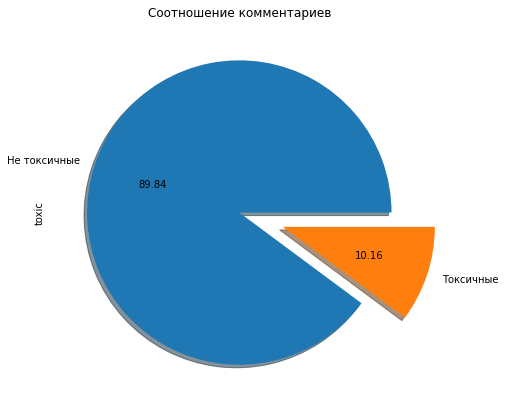

In [13]:
plt.figure(figsize=(7,7))
labels = ['Не токсичные', 'Токсичные']
exp = (0, 0.3)
data['toxic'].value_counts().plot(kind='pie', autopct='%.2f', labels=labels, explode=exp, shadow=True)
plt.title('Соотношение комментариев')
plt.rc('font', size= 15 ) 
plt.show()

### Вывод

Мы загрузили и подготовили данные:
1. Избавились от лишних символов с помощью регулярных выражений
2. Избавились от стоп-слов
3. Привели слова к их леммам
4. Удалили дубликаты

Посмотрели на соотношение токсичных комментариев к не токсичным. Токсичных комментариев 15986, это составляет примерно 10% от всех данных.

## Обучение

Разделим данные на тренировочную и тестовую выборки. Затем в пайплайне создадим признак `TF-IDF` и обучим на нем логистическую регрессию и дерево решией.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data['processed_text'], data['toxic'], stratify = data['toxic'])

In [15]:
pipeline = Pipeline([
    ('tf-idf',  TfidfVectorizer(decode_error='ignore')),
    ('models', LogisticRegression())
])

In [16]:
param_grid = [
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(1,4)
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(3,7) 
    }
]

In [17]:
randomized_search = RandomizedSearchCV(
    pipeline, 
    param_grid,
    scoring='f1', 
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('tf-idf',
                                              TfidfVectorizer(decode_error='ignore')),
                                             ('models', LogisticRegression())]),
                   n_jobs=-1,
                   param_distributions=[{'models': [LogisticRegression(random_state=42)],
                                         'models__C': range(1, 4)},
                                        {'models': [DecisionTreeClassifier(random_state=42)],
                                         'models__max_depth': range(3, 7)}],
                   scoring='f1')

In [18]:
print('Лучшая модель:',randomized_search.best_estimator_)

Лучшая модель: Pipeline(steps=[('tf-idf', TfidfVectorizer(decode_error='ignore')),
                ('models', LogisticRegression(C=3, random_state=42))])


In [19]:
print('Метрика f1 лучшей модели на тренировочных данных:',randomized_search.best_score_)

Метрика f1 лучшей модели на тренировочных данных: 0.7663511412555348


In [20]:
res = f1_score(y_test, randomized_search.predict(X_test))
print('Метрика f1 лучшей модели на тестовой выборке:', res)

Метрика f1 лучшей модели на тестовой выборке: 0.7695373665480427


Метрики логистической регрессии с параметром `C=3` больше 0.75, что удовлетворяет требованиям.

## Выводы

При подготовке данных мы выполнили следующие шаги:
1. Избавились от лишних символов с помощью регулярных выражений
2. Избавились от стоп-слов
3. Привели слова к их леммам с помощью функции из библиотеки `nltk` 
4. Удалили дубликаты

В данных присутствует дисбалланс классов, токсичные комментарии составляют 10% от всех записей, поэтому при разделении данных на выборки мы учитывали соотношение классов. 

Мы создали пайплайн, в котором кодируем признак с помощью `TfidfVectorizer` и обучаем две модели, подбирая параметры:
- `LogisticRegression` с параметром `C` от 1 до 3
- `DecisionTreeClassifier` с параметром `max_depth` от 3 до 6

Лучшей моделью оказалась логистическая регрессия с `C=3`. Ее метрика `F1` на тренировочных и тестовых данных равна примерно `0.76`, что удовлетворяет требованиям.